In [190]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [25]:
def read_X(filename):
    X = list()
    with open(filename) as f:
        while True:
            line = f.readline()
            if not line:
                break
            amplitudes = [int(x) for x in line.strip().split(',')]
            intervals = [int(x) for x in f.readline().strip().split(',')]
            
            f.readline() # skip an empty line
            X.append((amplitudes, intervals))
    return X

In [26]:
X_train_ecg = read_X('X.train.csv')
X_test_ecg = read_X('X.test.csv')
print len(X_train_ecg), len(X_test_ecg)

900 903


In [27]:
y_train = list()
for line in open('y.train.csv'):
    y_train.append(int(line))
print len(y_train)

900


In [28]:
def discretize(X):
    discrete = list()
    for amps, ints in X:
        amps = array(amps).astype(float)
        ints = array(ints).astype(float)
        alphas = arctan(amps / ints)

        amps = diff(amps)
        ints = diff(ints)
        alphas = diff(alphas)

        s = list()
        for ind, r, t, a in zip(range(600), amps, ints, alphas):
            c = 'x'
            if r > 0 and t > 0 and a > 0:
                c = 'a'
            if r <= 0 and t <= 0 and a > 0:
                c = 'b'
            if r > 0 and t <= 0 and a > 0:
                c = 'c'
            if r <= 0 and t > 0 and a <= 0:
                c = 'd'
            if r > 0 and t > 0 and a <= 0:
                c = 'e'
            if r <= 0 and t <= 0 and a <= 0:
                c = 'f'
            if c == 'x':
                print 'Very strange!!!', ind, r, t, a
            s.append(c)

        discrete.append(s)
    return discrete

In [29]:
X_train_discrete = discretize(X_train_ecg)
X_test_discrete = discretize(X_test_ecg)
print len(X_train_discrete), len(X_test_discrete)

900 903


In [30]:
from collections import defaultdict
from itertools import product

def vectorize(discrete):
    vectorized = list()
    for element in discrete:
        current = defaultdict(int)
        for j in range(597):
            current[tuple(element[j:j+3])] += 1

        vect = list()
        for a, b, c in product('abcdef', 'abcdef', 'abcdef'):
            vect.append(current[(a, b, c)])
        vectorized.append(vect)
    return array(vectorized).astype(float)

In [31]:
X_train = vectorize(X_train_discrete)
X_test = vectorize(X_test_discrete)
print X_train.shape, X_test.shape

(900, 216) (903, 216)


In [2]:
import pandas as pd
from sklearn.cross_validation import train_test_split

In [33]:
dt_train = pd.DataFrame(X_train)
dt_test = pd.DataFrame(X_test)

In [34]:
dt_train.to_csv('X_train_vectorize.csv')
dt_test.to_csv('X_test_vectorize.csv')

In [35]:
X_train, X_test, y_train, y_test = train_test_split(dt_train, y_train, test_size=0.3, random_state=42)
X_test, X_valid, y_test, y_valid  = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [40]:
X_train.to_csv('./data/X_train.csv')
X_test.to_csv('./data/X_test.csv')
X_valid.to_csv('./data/X_valid.csv')
pd.DataFrame(y_train).to_csv('./data/y_train.csv', index=False)
pd.DataFrame(y_test).to_csv('./data/y_test.csv', index=False)
pd.DataFrame(y_valid).to_csv('./data/y_valid.csv', index=False)

#### Загружаем данные

In [192]:
X_train = pd.read_csv('./data/X_train.csv')
X_test = pd.read_csv('./data/X_test.csv')
X_valid = pd.read_csv('./data/X_valid.csv')
y_train = pd.read_csv('./data/y_train.csv')
y_test = pd.read_csv('./data/y_test.csv')
y_valid = pd.read_csv('./data/y_valid.csv')

X_train.drop('Unnamed: 0', axis=1, inplace=True)
X_valid.drop('Unnamed: 0', axis=1, inplace=True)
X_test.drop('Unnamed: 0', axis=1, inplace=True)

X_sub = pd.read_csv('X_test_vectorize.csv')
X_sub.drop('Unnamed: 0', axis=1, inplace=True)

#### Исследования
получили данные. теперь смотрим что можно выжать из них

In [103]:
import seaborn as sns
from datetime import datetime

In [21]:
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.linear_model import LogisticRegression as SAG
from sklearn.preprocessing import PolynomialFeatures

In [8]:
def plot_quality(grid_searcher, param_name):
    means = []
    stds = []
    for elem in grid_searcher.grid_scores_:
        means.append(mean(elem.cv_validation_scores))
        stds.append(sqrt(var(elem.cv_validation_scores)))
    means = array(means)
    stds = array(stds)
    
    params = grid_searcher.param_grid
    
    figure(figsize=(8, 6))
    plot(params[param_name], means)
    fill_between(params[param_name], \
                 means + stds, means - stds, alpha = 0.3, facecolor='blue')
    xlabel(param_name)
    ylabel('AUC')

In [75]:
# scaler = preprocessing.StandardScaler().fit(X_train.drop('y', axis=1))
minmax = preprocessing.MinMaxScaler().fit(X_train)
X = pd.DataFrame(minmax.transform(X_train))

In [76]:
X.rename(columns=lambda x: 'f' + str(x), inplace=True)

In [77]:
X.head()
# print X.shape, y_train.shape

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f206,f207,f208,f209,f210,f211,f212,f213,f214,f215
0,0.000000,0.000000,0.000000,0.000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0,0.022222,0.000000,0.187500,0,0,0.000000
1,0.000000,0.000000,0.026316,0.025,0.000000,0.000000,0.571429,0.000000,0.272727,0.000000,...,0.00,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0,0.000000
2,0.340426,0.181818,0.552632,0.050,0.030303,0.411765,0.142857,0.000000,0.090909,0.041667,...,0.20,0.000000,0.210526,0,0.066667,0.000000,0.041667,0,0,0.000000
3,0.021277,0.090909,0.052632,0.050,0.000000,0.011765,0.000000,0.000000,0.000000,0.125000,...,0.04,0.181818,0.000000,0,0.011111,0.090909,0.145833,0,0,0.000000
4,0.000000,0.000000,0.000000,0.025,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,...,0.00,0.000000,0.000000,0,0.000000,0.000000,0.062500,0,0,0.022727


In [40]:
params = {'n_neighbors': arange(1, 200, 5)}
grid_searcher = GridSearchCV(KNN(),
                             params, cv=5, scoring='roc_auc', n_jobs=3)
grid_searcher.fit(X, y_train.ix[:, 0])

print grid_searcher.best_score_
print grid_searcher.best_estimator_

0.957314880526
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=26, p=2,
           weights='uniform')


#### выкидываем одну переменную для улучшения score

In [65]:
params = {'n_neighbors': arange(1, 40, 5)}

best_score = 0.957314880526
noise = []
index_noise = -1
estimators = []
for i in range(0, 216):
    grid_searcher_drop_noise = GridSearchCV(KNN(),
                             params, cv=5, scoring='roc_auc', n_jobs=3)
    grid_searcher_drop_noise.fit(X.drop('f' + str(i), axis=1),
                                 y_train.ix[:, 0])
    if (best_score < grid_searcher_drop_noise.best_score_):
        best_score = grid_searcher_drop_noise.best_score_
        noise.append(i)
        index_noise = i
        estimators.append(grid_searcher_drop_noise)

#### Долго и нудно выбрасываем всё по одной пока не станет хорошо

In [110]:
myX = X.copy()

In [111]:
params = {'n_neighbors': arange(1, 40, 5)}

best_score = 0.957314880526
was_improve = True
features = range(0, 216)
noise_steps = []
estimators = []
index_noise = -1
while(was_improve):
    print str(datetime.now()), best_score, noise_steps
    was_improve = False
    index_noise = -1
    best_seacher = 0
    for i in features:
        grid_searcher_drop_noise = GridSearchCV(KNN(),
                                 params, cv=5, scoring='roc_auc', n_jobs=3)
        
        grid_searcher_drop_noise.fit(myX.drop('f' + str(i), axis=1),
                                     y_train.ix[:, 0])
        if (best_score < grid_searcher_drop_noise.best_score_):
            best_score = grid_searcher_drop_noise.best_score_
            index_noise = i
            best_seacher = grid_searcher_drop_noise
            was_improve = True
        
    if (was_improve):
        myX.drop('f' + str(index_noise), axis=1, inplace=True)
        features.remove(index_noise)
        noise_steps.append(index_noise)
        estimators.append(best_seacher)

2016-03-13 00:41:40.901905 0.957314880526 []
2016-03-13 00:44:42.398662 0.959835596933 [158]
2016-03-13 00:47:41.283405 0.960768607712 [158, 19]
2016-03-13 00:50:37.568848 0.961283247937 [158, 19, 123]
2016-03-13 00:53:33.573794 0.961828154273 [158, 19, 123, 97]
2016-03-13 00:56:32.036592 0.962038772502 [158, 19, 123, 97, 54]
2016-03-13 00:59:39.385800 0.962403732059 [158, 19, 123, 97, 54, 90]
2016-03-13 01:02:38.267156 0.962495138401 [158, 19, 123, 97, 54, 90, 43]
2016-03-13 01:05:32.422075 0.962708014526 [158, 19, 123, 97, 54, 90, 43, 210]
2016-03-13 01:08:28.229401 0.962863745274 [158, 19, 123, 97, 54, 90, 43, 210, 52]
2016-03-13 01:11:23.100489 0.963043330248 [158, 19, 123, 97, 54, 90, 43, 210, 52, 168]
2016-03-13 01:14:16.590466 0.963074160834 [158, 19, 123, 97, 54, 90, 43, 210, 52, 168, 184]
2016-03-13 01:17:08.751028 0.963405684373 [158, 19, 123, 97, 54, 90, 43, 210, 52, 168, 184, 33]
2016-03-13 01:19:58.699416 0.963672883506 [158, 19, 123, 97, 54, 90, 43, 210, 52, 168, 184, 33,

-1 [2, 4] 0.964848833854


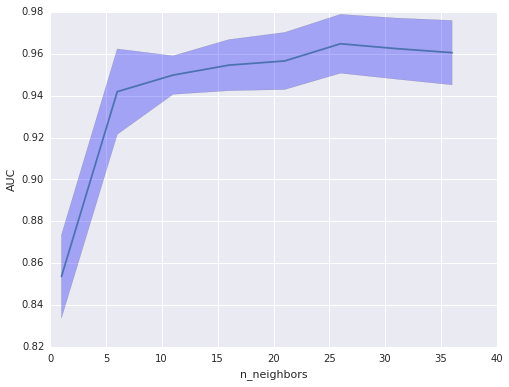

In [124]:
print index_noise, noise, best_score
plot_quality(estimators[-1], 'n_neighbors')

In [122]:
params = {'n_neighbors': arange(1, 40, 1)}


seacher = GridSearchCV(KNN(weights='distance'), params, cv=5, scoring='roc_auc', n_jobs=3)
seacher.fit(myX, y_train.ix[:, 0])
print seacher.best_score_
print seacher.best_estimator_

0.964425542168
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=26, p=2,
           weights='distance')


In [125]:
myX = X.copy()

In [126]:
params = {'n_neighbors': arange(1, 40, 5)}

best_score = 0.957314880526
was_improve = True
features = range(0, 216)
noise_steps = []
estimators = []
index_noise = -1
while(was_improve):
    print str(datetime.now()), best_score, noise_steps
    was_improve = False
    index_noise = -1
    best_seacher = 0
    for i in features:
        grid_searcher_drop_noise = GridSearchCV(KNN(weights='distance'),
                                 params, cv=5, scoring='roc_auc', n_jobs=3)
        
        grid_searcher_drop_noise.fit(myX.drop('f' + str(i), axis=1),
                                     y_train.ix[:, 0])
        if (best_score < grid_searcher_drop_noise.best_score_):
            best_score = grid_searcher_drop_noise.best_score_
            index_noise = i
            best_seacher = grid_searcher_drop_noise
            was_improve = True
        
    if (was_improve):
        myX.drop('f' + str(index_noise), axis=1, inplace=True)
        features.remove(index_noise)
        noise_steps.append(index_noise)
        estimators.append(best_seacher)

2016-03-13 10:44:36.484816 0.957314880526 []
2016-03-13 10:47:46.859092 0.960557989483 [158]
2016-03-13 10:50:54.792708 0.961461197291 [158, 19]
2016-03-13 10:54:01.131767 0.9618864286 [158, 19, 123]
2016-03-13 10:57:06.913436 0.962278325226 [158, 19, 123, 162]
2016-03-13 11:00:19.813462 0.962523609755 [158, 19, 123, 162, 184]
2016-03-13 11:03:23.307339 0.962945975161 [158, 19, 123, 162, 184, 210]
2016-03-13 11:06:27.292095 0.963188191119 [158, 19, 123, 162, 184, 210, 97]
2016-03-13 11:09:32.970265 0.963615998599 [158, 19, 123, 162, 184, 210, 97, 52]
2016-03-13 11:12:41.110488 0.964037958668 [158, 19, 123, 162, 184, 210, 97, 52, 89]
2016-03-13 11:15:48.737357 0.964159631121 [158, 19, 123, 162, 184, 210, 97, 52, 89, 70]
2016-03-13 11:18:51.808460 0.964280377294 [158, 19, 123, 162, 184, 210, 97, 52, 89, 70, 106]
2016-03-13 11:21:57.455324 0.964398257564 [158, 19, 123, 162, 184, 210, 97, 52, 89, 70, 106, 146]
2016-03-13 11:24:58.815996 0.96457973863 [158, 19, 123, 162, 184, 210, 97, 52, 8

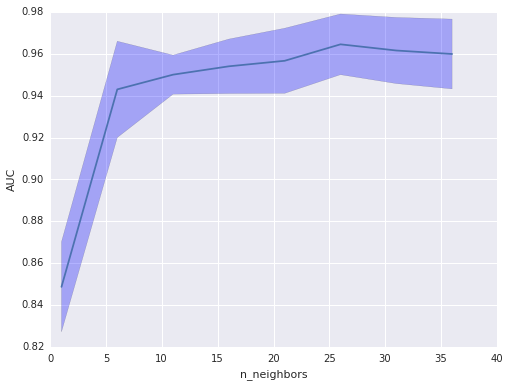

In [191]:
plot_quality(estimators[-1], 'n_neighbors')

In [218]:
X_sub = pd.read_csv('X_test_vectorize.csv')
X_sub.drop('Unnamed: 0', axis=1, inplace=True)

In [219]:
X_sub.head()

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,0,0,0,1,0,7,0,0,2,1,...,0,0,0,0,5,0,3,0,0,0
1,0,0,0,11,0,13,0,0,0,1,...,0,0,0,0,21,0,6,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,3,4,0,6,0,0,0,2,...,1,0,0,0,12,0,9,4,0,4
4,1,0,2,3,0,4,3,0,0,0,...,0,0,0,2,13,0,15,1,0,6


In [220]:

# scaler = preprocessing.StandardScaler().fit(X_train.drop('y', axis=1))
minmax = preprocessing.MinMaxScaler().fit(X_train)
X = pd.DataFrame(minmax.transform(X_train))
X.rename(columns=lambda x: 'f' + str(x), inplace=True)
testX = pd.DataFrame(minmax.transform(X_sub))
testX.rename(columns=lambda x: 'f' + str(x), inplace=True)

In [221]:
testX.drop({'f158', 'f19', 'f123',
             'f162', 'f184', 'f210',
             'f97', 'f52', 'f89',
             'f70', 'f106', 'f146',
             'f208'}, axis=1, inplace=True)
X.drop({'f158', 'f19', 'f123',
             'f162', 'f184', 'f210',
             'f97', 'f52', 'f89',
             'f70', 'f106', 'f146',
             'f208'}, axis=1, inplace=True)

In [222]:
clf = grid_searcher.best_estimator_.fit(X, y_train)
results = clf.predict_proba(testX)[:, 1]
f = open('y.knn.noise.drop.csv', 'w')
print >> f, 'Id,Prediction'
for i, result in enumerate(results):
    print >> f, str(i+1) + ',' + str(result)
f.close()

/home/dezzan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':


In [154]:
clf = estimators[-1].best_estimator_.fit(myX.ix[0:200,], y_train.ix[0:200,0])
knn_y = clf.predict_proba(myX)[:, 1]

In [156]:
X_train['knn'] = knn_y

In [176]:
# params = {'n_estimators': arange(150, 700, 100),
#          'max_depth': arange(4, 40, 4),
#          'min_samples_leaf': [1, 5]}
params = {'n_estimators': arange(100, 1700, 100)}
grid_searcher_rf = GridSearchCV(RFC(),
                             params, cv=5, scoring='roc_auc', n_jobs=1)
grid_searcher_rf.fit(X_train.ix[201:,], y_train.ix[201:,0])

print grid_searcher_rf.best_score_
print grid_searcher_rf.best_estimator_
# 0.969393256461 - RF, max_depth=16, n_estimators=450, data after StandardScaler() and select most important
# 0.968850854222 - RF, max_depth=NONE, n_estimators=550, data after StandardScaler() and select most important

0.964829824673
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


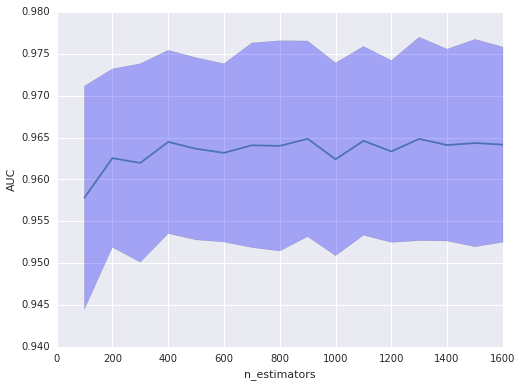

In [160]:
plot_quality(grid_searcher_rf, 'n_estimators')

In [177]:
# rf_clf = grid_searcher_rf.best_estimator_
# features_importance = rf_clf.feature_importances_.copy()
print mean(features_importance)
f = features_importance > 0.004

0.00460829493088


In [186]:
params = {'n_estimators': arange(100, 1300, 200),
         'max_depth': np.append(arange(4, 24, 8), None)}
# params = {'n_estimators': arange(100, 1700, 100)}
grid_searcher_rf = GridSearchCV(RFC(),
                             params, cv=5, scoring='roc_auc', n_jobs=1)
grid_searcher_rf.fit(X_train.ix[201:,f], y_train.ix[201:,0])

print grid_searcher_rf.best_score_
print grid_searcher_rf.best_estimator_

0.969029095713
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [188]:
plot_quality(grid_searcher_rf, 'n_estimators')

In [189]:
grid_searcher_rf.best_estimator_.feature_importances_

array([ 0.00600295,  0.0236623 ,  0.00923427,  0.00971555,  0.01739658,
        0.05366589,  0.0073973 ,  0.00485352,  0.01230894,  0.06254077,
        0.01414287,  0.02561232,  0.01772161,  0.01297899,  0.0073147 ,
        0.01003357,  0.00637394,  0.01708105,  0.01093721,  0.0208263 ,
        0.0124339 ,  0.00543622,  0.00736623,  0.01303182,  0.00785329,
        0.01136113,  0.01358595,  0.00778023,  0.00475822,  0.0071349 ,
        0.00694591,  0.00733876,  0.01621069,  0.01159028,  0.00702584,
        0.04116931,  0.01648337,  0.08584014,  0.01644211,  0.0260565 ,
        0.00485151,  0.00766203,  0.0370086 ,  0.01175131,  0.00821861,
        0.01016489,  0.011715  ,  0.01009221,  0.04510444,  0.0090791 ,
        0.0093752 ,  0.15933169])

In [137]:
clf = grid_searcher.best_estimator_.fit(X, y_train)
r = clf.predict_proba(X)[:, 1]
X_train['knn'] = r

In [112]:
params = {'n_neighbors': arange(1, 200, 5)}
grid_searcher = GridSearchCV(KNN(),
                             params, cv=5, scoring='roc_auc', n_jobs=3)
grid_searcher.fit(X.drop('y', axis=1), y_train)

print grid_searcher.best_score_
print grid_searcher.best_estimator_

0.954893617967
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=31, p=2,
           weights='uniform')


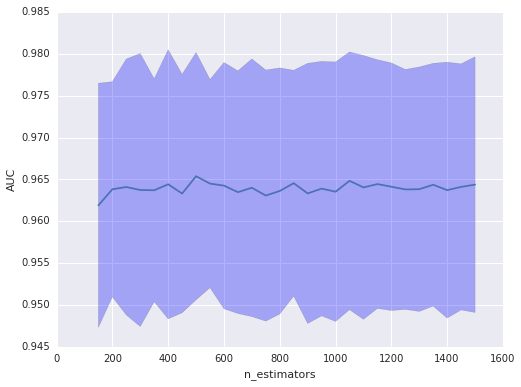

In [154]:
plot_quality(grid_searcher, 'n_estimators')

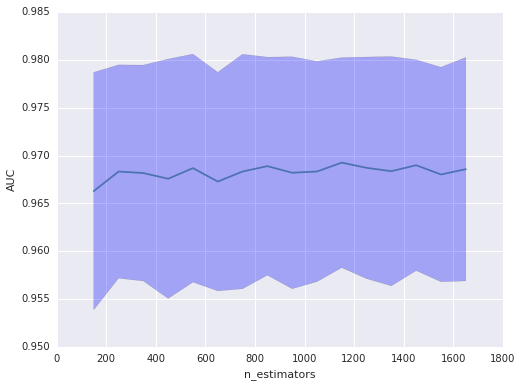

In [192]:
plot_quality(grid_searcher, 'n_estimators')

In [158]:
rf = grid_searcher.best_estimator_

In [185]:
f = rf.feature_importances_ > 0.01

In [169]:
rf.feature_importances_

array([ 0.00259745,  0.00192837,  0.00291831,  0.00184098,  0.00355852,
        0.00275781,  0.00092847,  0.00120219,  0.00110291,  0.00151396,
        0.00079824,  0.00297416,  0.00075804,  0.00123317,  0.00509736,
        0.00851448,  0.00169435,  0.01354587,  0.00604324,  0.00183859,
        0.00292858,  0.00325994,  0.0014587 ,  0.00347862,  0.00187205,
        0.00177856,  0.00085228,  0.00462046,  0.00227996,  0.00279283,
        0.01169732,  0.00144989,  0.00515131,  0.02036391,  0.00167067,
        0.00539715,  0.00114252,  0.00092089,  0.00141911,  0.00379177,
        0.0085151 ,  0.00130672,  0.00198415,  0.00382111,  0.00302818,
        0.00116635,  0.01080385,  0.00177211,  0.00340165,  0.00116807,
        0.00177803,  0.00339133,  0.03415617,  0.00106845,  0.00152173,
        0.00126493,  0.00153686,  0.00124885,  0.00285537,  0.00149438,
        0.00075153,  0.00074305,  0.00160421,  0.02730946,  0.02174348,
        0.00066655,  0.00202604,  0.00188429,  0.00128912,  0.00